In [4]:
# Quick example of how to load data preprocessed data
# and generate a 3d animated topo map of the evoked data 
# as demonstrated here: https://gist.github.com/kingjr/061f28265555ac97329d2c80132d1b57

import mne

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import Delaunay
import ipyvolume as p3

# First of all, we have to perform a segmentation
# I already extracted the necessary event timings and divided feedback
# by maze vs. no maze, left vs. right and of course reward vs. no reward
# for the fMRI analysis. Here, the same timings shall be used in a
# different format.
event_file1 = './events/events1-eve.fif'
events1 = mne.read_events(event_file1)
event_file2 = './events/events2-eve.fif'
events2 = mne.read_events(event_file2)

# The event data is a x-by-3 array with the rows containing the events
# in chronological order and the columns their respective event info 
# (timing in sample points, value of the event channel before/after,
# integer assigned to an event id)

# Define the event ids
event_id = {'reward_left_maze': 1, 'reward_right_maze': 2,
            'reward_left_nomaze': 3, 'reward_right_nomaze': 4,
            'noreward_left_maze': 5, 'noreward_right_maze': 6,
            'noreward_left_nomaze': 7, 'noreward_right_nomaze': 8,
            'slows': 9}

In [3]:
# Load the raw data for the first and second sub into memory
file1 = './raw/pilot01_tmaze_ICA_corr-raw.fif'
file2 = './raw/pilot02_tmaze_ICA_corr-raw.fif' 
raw1 = mne.io.read_raw_fif(file1, preload=True)
raw2 = mne.io.read_raw_fif(file2, preload=True)

Opening raw data file /Volumes/INTENSO/EEG_fMRI_tmaze/raw/pilot01_tmaze_ICA_corr-raw.fif...
    Range : 0 ... 1036983 =      0.000 ...  1036.983 secs
Ready.
Reading 0 ... 1036983  =      0.000 ...  1036.983 secs...
Opening raw data file /Volumes/INTENSO/EEG_fMRI_tmaze/raw/pilot02_tmaze_ICA_corr-raw.fif...
    Range : 0 ... 389999 =      0.000 ...   389.999 secs
Ready.
Reading 0 ... 389999  =      0.000 ...   389.999 secs...


In [3]:
idx = mne.pick_types(raw1.info,eeg=True)
names = [raw1.ch_names[i] for i in idx]

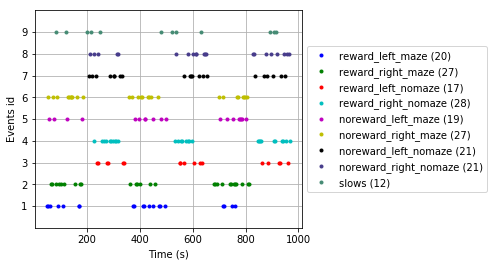

In [13]:
# Just to check on the distribution, plot the event IDs across time
onsets = mne.viz.plot_events(events1, raw1.info['sfreq'], raw1.first_samp, 
                             color=None, event_id=event_id)

In [7]:
# Perform a segmentation based on the events and event_ids on both

tmin, tmax = -0.3, 0.8
baseline = -0.3, -0.1

epochs = mne.Epochs(raw1, events=events1, event_id=event_id, 
                    picks=idx, tmin=tmin, tmax=tmax,
                    preload=True, baseline=baseline)

epochs = mne.Epochs(raw2, events=events2, event_id=event_id, 
                    picks=idx, tmin=tmin, tmax=tmax,
                    preload=True, baseline=baseline)

192 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 192 events and 1101 original time points ...
0 bad epochs dropped
50 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 50 events and 1101 original time points ...
0 bad epochs dropped


In [5]:
reward = mne.grand_average([epochs1['reward'].average(),
                            epochs2['reward'].average()])

noreward = mne.grand_average([epochs1['no_reward'].average(),
                              epochs2['no_reward'].average()])

Identifying common channels ...
all channels are corresponding, nothing to do.
Identifying common channels ...
all channels are corresponding, nothing to do.


In [6]:
pool1 = reward.data
pool2 = noreward.data

FCz= np.array([pool1[21], pool1[14], pool1[5], 
               pool1[15], pool1[121], pool1[7]]).mean(axis=0)
P8= np.array([pool1[170], pool1[177], pool1[178],
              pool1[169], pool1[168], pool1[160], pool1[159]]).mean(axis=0)
pool1[14] = FCz
pool1[169] = P8
reward.data = pool1

FCz= np.array([pool2[21], pool2[14], pool2[5], 
               pool2[15], pool2[121], pool2[7]]).mean(axis=0)
P8= np.array([pool2[170], pool2[177], pool2[178],
              pool2[169], pool2[168], pool2[160], pool2[159]]).mean(axis=0)
pool2[14] = FCz
pool2[169] = P8
noreward.data = pool2

difference_wave = mne.combine_evoked((reward,noreward),[-1,1])

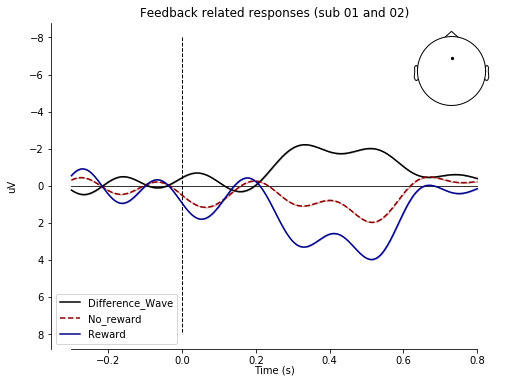

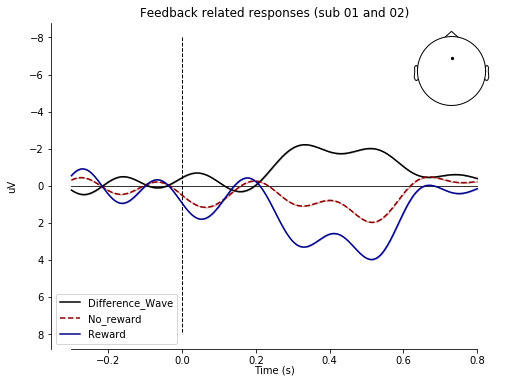

In [8]:
ch_name = 'E15'
picks = reward.ch_names.index(ch_name)

colors = dict(Reward = 'darkblue', No_reward = 'darkred', 
              Difference_Wave = 'black')

evoked_dict = {'Reward': reward, 'No_reward': noreward, 
               'Difference_Wave': difference_wave}

linestyles = dict(Reward = '-', No_reward = '--', 
                  Difference_Wave = '-')

ylim = dict(eeg=[-8,8])

mne.viz.plot_compare_evokeds(evoked_dict, picks=picks, 
                             truncate_yaxis=False, truncate_xaxis=False,
                             colors=colors, linestyles=linestyles,
                             invert_y=True, ylim = ylim,
                             title='Feedback related responses (sub 01 and 02)',
                             show_sensors=True)

In [9]:
cmap = plt.get_cmap('RdBu_r')
data = np.array(difference_wave.data)

n_chans, n_times = data.shape
vmax = data.max()
data[data<=-vmax] = -vmax
data[data>=vmax] = vmax
data -= -vmax
data /= 2*vmax
colors = np.reshape(cmap(data.ravel())[:, :3], [n_chans, n_times, 3])
colors = colors.transpose(1, 0, 2)

pos3D = np.array([ch['loc'][:3] for ch in reward.info['chs']])
tri3D = Delaunay(pos3D).convex_hull

In [10]:
fig = p3.figure()
s = p3.plot_trisurf(pos3D[:, 0], pos3D[:, 1], [pos3D[:, 2] for _ in range(n_times)],
                    triangles=tri3D, color=colors)
p3.xyzlim(pos3D.min(), pos3D.max())
p3.animation_control(s, interval=10)
p3.show()

In [13]:
pos = mne.find_layout(reward.info).pos[:, :3]
pos -= pos.mean(0, keepdims=True)
pos[:, 2] = (1-(pos[:, 0] ** 2 + pos[:, 1] ** 2))/1e3
tri2D = Delaunay(pos).convex_hull

In [14]:
fig = p3.figure()
s = p3.plot_trisurf(pos[:, 0], pos[:, 1], [pos[:, 2] for _ in range(n_times)],
                    triangles=tri2D, color=colors)
p3.xyzlim(pos.min(), pos.max())
p3.animation_control(s, interval=10, add=True)
p3.show()